In [1]:
import crispr_hmm
from Bio import SeqIO
import random
import matplotlib.pyplot as plt
import numpy as np
from Bio import pairwise2
import csv
import pandas as pd
from collections import Counter

/homes8/jingyuan/.local/lib/python3.9/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [2]:
ref = "TTTCTTGGCTTTATATATCTTGTGGAAAGGACGAAACACCGGTCCCCTCCACCCCACAGTGGGGTTAGAGCTAGAAATAGCAAGTTAACCT"
HMM_result = pd.read_csv("./output/HMM_hgRNA2_result.csv")
NW_result = pd.read_csv("./output/NW_hgRNA2_result.csv")

In [3]:
import gzip

file_path = "./output/CRISPResso/CRISPResso_on_nhej/hgRNA2.CRISPResso_output.fastq.gz"

CRISPResso_result_fq = []

with gzip.open(file_path, "r") as file:
    while True:
        line1 = file.readline()
        line2 = file.readline()
        line3 = file.readline()
        line4 = file.readline()
        if not line2:
            break

        CRISPResso_result_fq.append(line3.decode().strip())

In [4]:
CRISPResso_result = {"score": [float(i.split(" ")[2][11:]) for i in CRISPResso_result_fq],
                     "aligned_ref":[i.split(" ")[-2][8:] for i in CRISPResso_result_fq],
                     "aligned_read":[i.split(" ")[-1][8:] for i in CRISPResso_result_fq]
                    }
CRISPResso_result = pd.DataFrame(data=CRISPResso_result)

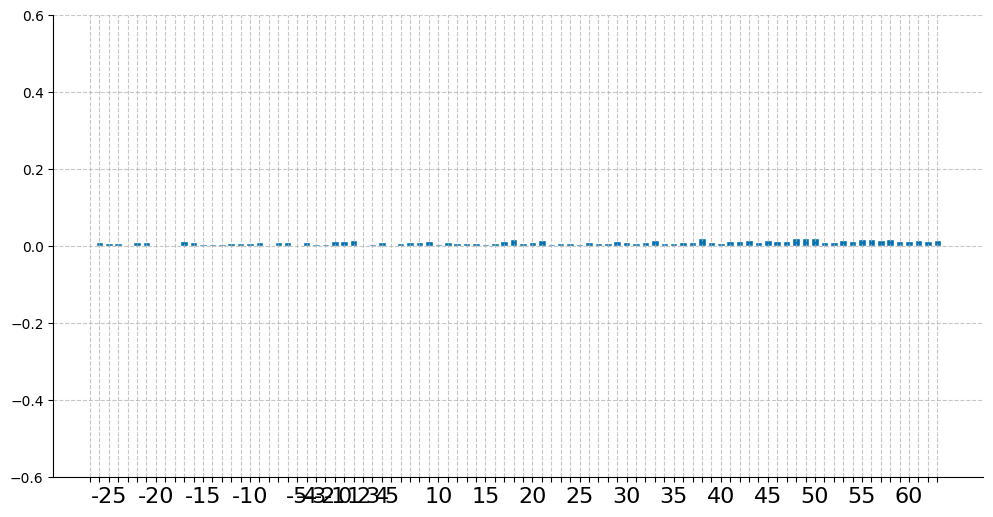

In [35]:
fig, ax = plt.subplots(figsize=(12, 6))

# Create the first histogram
weights1 = np.ones_like(HMM_sub) / len(HMM_sub)

max_pos = 91
pam_pos = 27
bin_edges = np.arange(0.5, max_pos+0.5)
pos = [j for j in range(max_pos)]
pos_tick = [str(i-pam_pos) if abs(i-pam_pos)<6 or (i-pam_pos) % 5 == 0 else "" for i in range(max_pos)]
bar_labels = ["0"] + [j for j in ref]
bar_labels = bar_labels[:max_pos]

plt.hist(HMM_sub, bins=bin_edges, edgecolor='white', alpha=1, \
         weights=weights1, rwidth=0.8, color='#0072B2')

# Customize x-axis
ax.set_xticks(pos)
ax.set_xticklabels(pos_tick, fontsize=16)

# Customize y-axis
ax.set_ylim((-0.6, 0.6))

# Customize grid
ax.xaxis.grid(True, linestyle='--', alpha=0.7)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [5]:
offset=35
back_offset=-10

counter = Counter(list(HMM_result["aligned_read"]))

top_sequences = sorted(counter.items(), key=lambda x: x[1], reverse=True)[:100]
top_sequences = [i for i in top_sequences if i[0] != ref]

selected_sequences = []
selected_sequences_percentage = []
for s in top_sequences:
    if s[0].find("-") == 42:
        selected_sequences.append(s[0][offset:back_offset])
        selected_sequences_percentage.append(s[1]/len(HMM_result))
selected_sequences_stripped = [s.replace("-","") for s in selected_sequences]

In [7]:
counter = Counter(list(CRISPResso_result["aligned_read"]))

top_sequences = sorted(counter.items(), key=lambda x: x[1], reverse=True)[:100]
top_sequences = [i for i in top_sequences if i[0] != ref]

for s in top_sequences:
    ss = s[0][offset:back_offset].replace("-","")
    if ss in selected_sequences_stripped:
        print(selected_sequences[selected_sequences_stripped.index(ss)] + "   " + 
              s[0][offset:back_offset] + "   " + "{:.1%}".format(
              selected_sequences_percentage[selected_sequences_stripped.index(ss)]))

ACACCGG--------------------GGTTAGAGCTAGAAATAGC   ACACCGG--------------------GGTTAGAGCTAGAAATAGC   5.1%
ACACCGG-----------------TGGGGTTAGAGCTAGAAATAGC   ACACCGGT-----------------GGGGTTAGAGCTAGAAATAGC   3.5%
ACACCGG----------------------TTAGAGCTAGAAATAGC   ACACCGGT----------------------TAGAGCTAGAAATAGC   1.0%
ACACCGG-------------------GGGTTAGAGCTAGAAATAGC   ACACCGG-------------------GGGTTAGAGCTAGAAATAGC   0.6%
ACACCGG---------------------GTTAGAGCTAGAAATAGC   ACACCGG---------------------GTTAGAGCTAGAAATAGC   0.4%
ACACCGG-----------------------TAGAGCTAGAAATAGC   ACACCGGT-----------------------AGAGCTAGAAATAGC   0.3%
ACACCGG----------------------------CTAGAAATAGC   ACACCGG----------------------------CTAGAAATAGC   0.2%
ACACCGG--------------------------AGCTAGAAATAGC   ACACCGG--------------------------AGCTAGAAATAGC   0.2%
ACACCGG-----------------------------TAGAAATAGC   ACACCGGT-----------------------------AGAAATAGC   0.2%
ACACCGG-----------------------------------TAGC   ACACCGGT----------------

In [9]:
HMM_deletion_start = [i.find("-") for i in HMM_result["aligned_read"]]
HMM_deletion_start = [i for i in HMM_deletion_start if i != -1 and i < len(ref)]

NW_deletion_start = [i.find("-") for i in NW_result["aligned_read"]]
NW_deletion_start = [i for i in NW_deletion_start if i != -1 and i < len(ref)]

CRISPResso_deletion_start = [i.find("-") for i in list(CRISPResso_result["aligned_read"])]
CRISPResso_deletion_start = [i for i in CRISPResso_deletion_start if i != -1 and i < len(ref)]

In [10]:
offset = 35

ref = ref[offset:]
HMM_deletion_start = [i-offset for i in HMM_deletion_start]
NW_deletion_start = [i-offset for i in NW_deletion_start]
CRISPResso_deletion_start = [i-offset for i in CRISPResso_deletion_start]

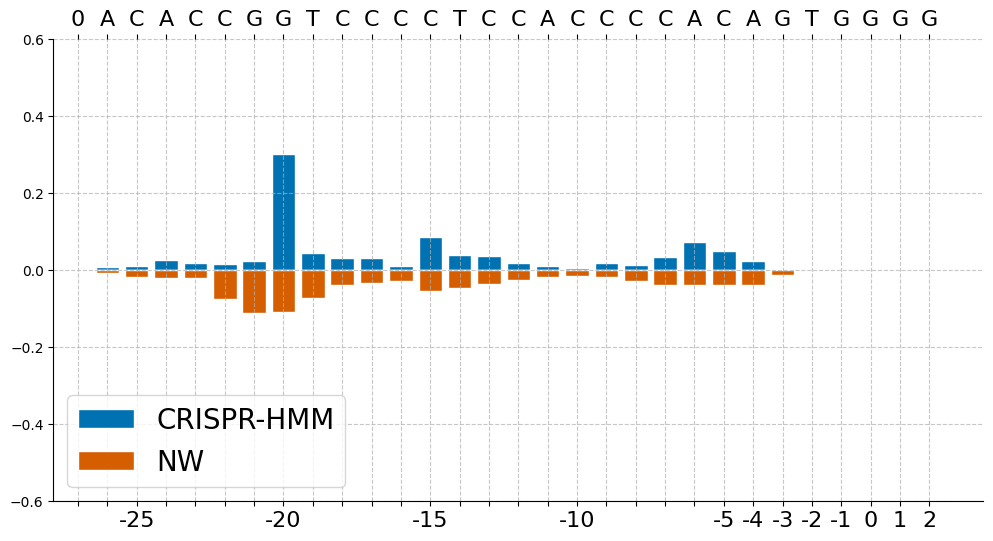

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))

# Create the first histogram
weights1 = np.ones_like(HMM_deletion_start) / len(HMM_deletion_start)
weights2 = np.ones_like(NW_deletion_start) / len(NW_deletion_start)

max_pos = 30
pam_pos = 27
bin_edges = np.arange(0.5, max_pos+0.5)
pos = [j for j in range(max_pos)]
pos_tick = [str(i-pam_pos) if abs(i-pam_pos)<6 or (i-pam_pos) % 5 == 0 else "" for i in range(max_pos)]
bar_labels = ["0"] + [j for j in ref]
bar_labels = bar_labels[:max_pos]

plt.hist(HMM_deletion_start, bins=bin_edges, edgecolor='white', alpha=1, \
         label='CRISPR-HMM', weights=weights1, rwidth=0.8, color='#0072B2')
n, bins, patches = plt.hist(NW_deletion_start, bins=bin_edges, edgecolor='white', \
         alpha=1, label='NW', weights=weights2, rwidth=0.8, color='#D55E00')
for patch in patches:
    patch.set_height(-patch.get_height())

# Customize x-axis
ax.set_xticks(pos)
ax.set_xticklabels(pos_tick, fontsize=16)

# Customize y-axis
ax.set_ylim((-0.6, 0.6))

# Customize grid
ax.xaxis.grid(True, linestyle='--', alpha=0.7)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Create a secondary x-axis on the top
ax2 = ax.twiny()

# Set the tick positions and labels for the secondary x-axis
ax2.set_xticks(pos)
ax2.set_xticklabels(bar_labels, fontsize=16)

# Remove the spines for the secondary x-axis
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)

# Align the secondary x-axis with the primary x-axis
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(ax.get_xticks())

# Add a legend
ax.legend(loc='lower left', fontsize=20)

# Show the plot
plt.show()

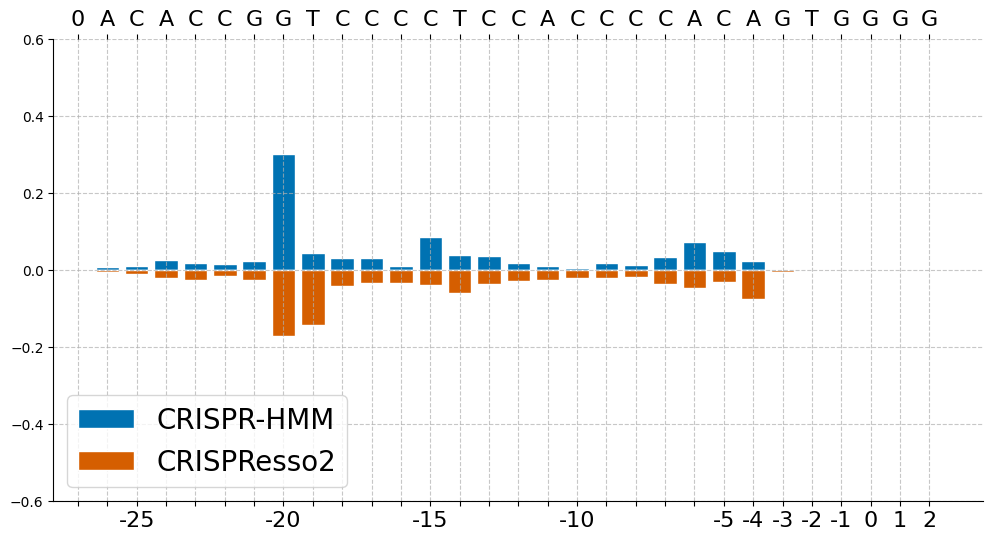

In [12]:
fig, ax = plt.subplots(figsize=(12, 6))

# Create the first histogram
weights1 = np.ones_like(HMM_deletion_start) / len(HMM_deletion_start)
weights2 = np.ones_like(CRISPResso_deletion_start) / len(CRISPResso_deletion_start)

max_pos = 30
pam_pos = 27
bin_edges = np.arange(0.5, max_pos+0.5)
pos = [j for j in range(max_pos)]
pos_tick = [str(i-pam_pos) if abs(i-pam_pos)<6 or (i-pam_pos) % 5 == 0 else "" for i in range(max_pos)]
bar_labels = ["0"] + [j for j in ref]
bar_labels = bar_labels[:max_pos]

plt.hist(HMM_deletion_start, bins=bin_edges, edgecolor='white', alpha=1, \
         label='CRISPR-HMM', weights=weights1, rwidth=0.8, color='#0072B2')
n, bins, patches = plt.hist(CRISPResso_deletion_start, bins=bin_edges, edgecolor='white', \
         alpha=1, label='CRISPResso2', weights=weights2, rwidth=0.8, color='#D55E00')
for patch in patches:
    patch.set_height(-patch.get_height())

# Customize x-axis
ax.set_xticks(pos)
ax.set_xticklabels(pos_tick, fontsize=16)

# Customize y-axis
ax.set_ylim((-.6, .6))

# Customize grid
ax.xaxis.grid(True, linestyle='--', alpha=0.7)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Create a secondary x-axis on the top
ax2 = ax.twiny()

# Set the tick positions and labels for the secondary x-axis
ax2.set_xticks(pos)
ax2.set_xticklabels(bar_labels, fontsize=16)

# Remove the spines for the secondary x-axis
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)

# Align the secondary x-axis with the primary x-axis
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(ax.get_xticks())

# Add a legend
ax.legend(loc='lower left', fontsize=20)

# Show the plot
plt.show()

In [13]:
ref = "TTTCTTGGCTTTATATATCTTGTGGAAAGGACGAAACACCGGTCCCCTCCACCCCACAGTGGGGTTAGAGCTAGAAATAGCAAGTTAACCT"

In [14]:
HMM_insertion_start = [i.find("-") for i in HMM_result["aligned_ref"]]
HMM_insertion_start = [i for i in HMM_insertion_start if i != -1 and i < len(ref)]

NW_insertion_start = [i.find("-") for i in NW_result["aligned_ref"]]
NW_insertion_start = [i for i in NW_insertion_start if i != -1 and i < len(ref)]

CRISPResso_insertion_start = [i.find("-") for i in list(CRISPResso_result["aligned_ref"])]
CRISPResso_insertion_start = [i for i in CRISPResso_insertion_start if i != -1 and i < len(ref)]

In [15]:
offset = 35

ref = ref[offset:]
HMM_insertion_start = [i-offset for i in HMM_insertion_start]
NW_insertion_start = [i-offset for i in NW_insertion_start]
CRISPResso_insertion_start = [i-offset for i in CRISPResso_insertion_start]

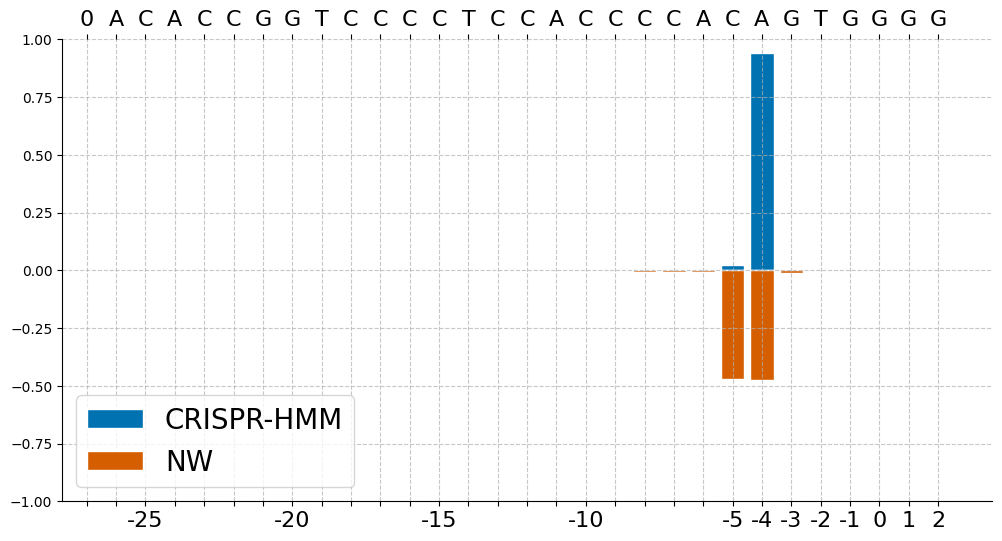

In [16]:
fig, ax = plt.subplots(figsize=(12, 6))

# Create the first histogram
weights1 = np.ones_like(HMM_insertion_start) / len(HMM_insertion_start)
weights2 = np.ones_like(NW_insertion_start) / len(NW_insertion_start)

max_pos = 30
pam_pos = 27
bin_edges = np.arange(0.5, max_pos+0.5)
pos = [j for j in range(max_pos)]
pos_tick = [str(i-pam_pos) if abs(i-pam_pos)<6 or (i-pam_pos) % 5 == 0 else "" for i in range(max_pos)]
bar_labels = ["0"] + [j for j in ref]
bar_labels = bar_labels[:max_pos]

plt.hist(HMM_insertion_start, bins=bin_edges, edgecolor='white', alpha=1, \
         label='CRISPR-HMM', weights=weights1, rwidth=0.8, color='#0072B2')
n, bins, patches = plt.hist(NW_insertion_start, bins=bin_edges, edgecolor='white', \
         alpha=1, label='NW', weights=weights2, rwidth=0.8, color='#D55E00')
for patch in patches:
    patch.set_height(-patch.get_height())

# Customize x-axis
ax.set_xticks(pos)
ax.set_xticklabels(pos_tick, fontsize=16)

# Customize y-axis
ax.set_ylim((-1, 1))

# Customize grid
ax.xaxis.grid(True, linestyle='--', alpha=0.7)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Create a secondary x-axis on the top
ax2 = ax.twiny()

# Set the tick positions and labels for the secondary x-axis
ax2.set_xticks(pos)
ax2.set_xticklabels(bar_labels, fontsize=16)

# Remove the spines for the secondary x-axis
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)

# Align the secondary x-axis with the primary x-axis
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(ax.get_xticks())

# Add a legend
ax.legend(loc='lower left', fontsize=20)

# Show the plot
plt.show()

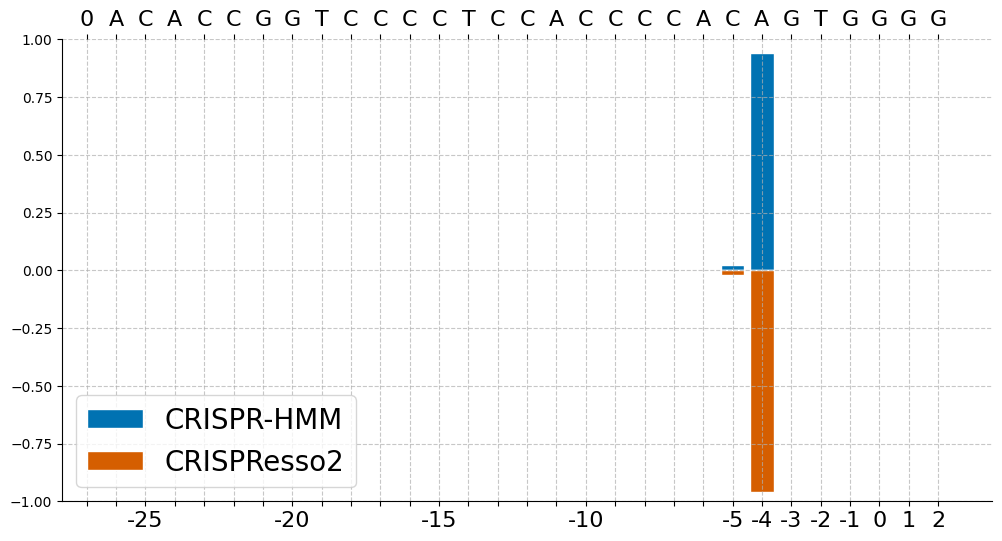

In [17]:
fig, ax = plt.subplots(figsize=(12, 6))

# Create the first histogram
weights1 = np.ones_like(HMM_insertion_start) / len(HMM_insertion_start)
weights2 = np.ones_like(CRISPResso_insertion_start) / len(CRISPResso_insertion_start)

max_pos = 30
pam_pos = 27
bin_edges = np.arange(0.5, max_pos+0.5)
pos = [j for j in range(max_pos)]
pos_tick = [str(i-pam_pos) if abs(i-pam_pos)<6 or (i-pam_pos) % 5 == 0 else "" for i in range(max_pos)]
bar_labels = ["0"] + [j for j in ref]
bar_labels = bar_labels[:max_pos]

plt.hist(HMM_insertion_start, bins=bin_edges, edgecolor='white', alpha=1, \
         label='CRISPR-HMM', weights=weights1, rwidth=0.8, color='#0072B2')
n, bins, patches = plt.hist(CRISPResso_insertion_start, bins=bin_edges, edgecolor='white', \
         alpha=1, label='CRISPResso2', weights=weights2, rwidth=0.8, color='#D55E00')
for patch in patches:
    patch.set_height(-patch.get_height())

# Customize x-axis
ax.set_xticks(pos)
ax.set_xticklabels(pos_tick, fontsize=16)

# Customize y-axis
ax.set_ylim((-1, 1))

# Customize grid
ax.xaxis.grid(True, linestyle='--', alpha=0.7)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Create a secondary x-axis on the top
ax2 = ax.twiny()

# Set the tick positions and labels for the secondary x-axis
ax2.set_xticks(pos)
ax2.set_xticklabels(bar_labels, fontsize=16)

# Remove the spines for the secondary x-axis
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)

# Align the secondary x-axis with the primary x-axis
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(ax.get_xticks())

# Add a legend
ax.legend(loc='lower left', fontsize=20)

# Show the plot
plt.show()